# SLSTMCell

## SLSTMCell 定义

In [1]:
import tensorflow as tf

from tensorflow.python.distribute import distribution_strategy_context as ds_context
from tensorflow.python.eager import context
from tensorflow.python.framework import ops
from tensorflow.python.framework import tensor_shape
from tensorflow.python.keras import activations
from tensorflow.python.keras import backend as K
from tensorflow.python.keras import constraints
from tensorflow.python.keras import initializers
from tensorflow.python.keras import regularizers
from tensorflow.python.keras.engine.base_layer import Layer
from tensorflow.python.keras.engine.input_spec import InputSpec
from tensorflow.python.keras.utils import generic_utils
from tensorflow.python.keras.utils import tf_utils
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import control_flow_ops
from tensorflow.python.ops import control_flow_util
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import state_ops
from tensorflow.python.platform import tf_logging as logging
from tensorflow.python.training.tracking import base as trackable
from tensorflow.python.training.tracking import data_structures
from tensorflow.python.util import nest
from tensorflow.python.util.tf_export import keras_export
from tensorflow.tools.docs import doc_controls

class SLSTMCell(tf.keras.layers.Layer):
    """
    继承Layer并重载了5个函数，参照TF中LSTMCell源码并做了修改，源码见第 6.3.1.3 节（上一节）
    随机遮挡来自类DropoutRNNCellMixin
    """
    
    def __init__(self,
                   units,
                   activation='tanh',
                   recurrent_activation='hard_sigmoid',
                   use_bias=True,
                   kernel_initializer='glorot_uniform',
                   recurrent_initializer='orthogonal',
                   bias_initializer='zeros',
                   unit_forget_bias=True,
                   kernel_regularizer=None,
                   recurrent_regularizer=None,
                   bias_regularizer=None,
                   kernel_constraint=None,
                   recurrent_constraint=None,
                   bias_constraint=None,
                   dropout=0.,
                   recurrent_dropout=0.,
                   implementation=1,
                   **kwargs):
        #print("init start")
        self._enable_caching_device = kwargs.pop('enable_caching_device', False)
        super(SLSTMCell, self).__init__(**kwargs)
        self.num_gates = 6
        self.units = units
        self.activation = activations.get(activation)
        self.recurrent_activation = activations.get(recurrent_activation)
        self.use_bias = use_bias

        self.kernel_initializer = initializers.get(kernel_initializer)
        self.recurrent_initializer = initializers.get(recurrent_initializer)
        self.bias_initializer = initializers.get(bias_initializer)
        self.unit_forget_bias = unit_forget_bias

        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.recurrent_regularizer = regularizers.get(recurrent_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)

        self.kernel_constraint = constraints.get(kernel_constraint)
        self.recurrent_constraint = constraints.get(recurrent_constraint)
        self.bias_constraint = constraints.get(bias_constraint)

        self.dropout = min(1., max(0., dropout))
        self.recurrent_dropout = min(1., max(0., recurrent_dropout))
        if self.recurrent_dropout != 0 and implementation != 1:
            logging.debug(RECURRENT_DROPOUT_WARNING_MSG)
            self.implementation = 1
        else:
            self.implementation = implementation
        # tuple(_ListWrapper) was silently dropping list content in at least 2.7.10,
        # and fixed after 2.7.16. Converting the state_size to wrapper around
        # NoDependency(), so that the base_layer.__setattr__ will not convert it to
        # ListWrapper. Down the stream, self.states will be a list since it is
        # generated from nest.map_structure with list, and tuple(list) will work
        # properly.
        self.state_size = data_structures.NoDependency([self.units, self.units])
        self.output_size = self.units
        
        self.SeasonalGate = False
        
        #print("init end")

    
    
    @tf_utils.shape_type_conversion
    def build(self, input_shape):
        print("build start")

        input_dim = input_shape[-1]
        self.kernel = self.add_weight(
            # W_x: 用于和当前时刻隐层输入x做乘法的矩阵
            # 加入季节门，将self.units * 4改为self.units * 6 
            # 这里
            shape=(input_dim, self.units * self.num_gates),
            name='kernel',
            initializer=self.kernel_initializer,
            regularizer=self.kernel_regularizer,
            constraint=self.kernel_constraint)

        self.recurrent_kernel = self.add_weight(
            # W_h: 用于和前一时刻隐层输出h做乘法的矩阵
            # 加入季节门，将self.units * 4改为self.units * 6
            shape=(self.units, self.units * self.num_gates),
            name='recurrent_kernel',
            initializer=self.recurrent_initializer,
            regularizer=self.recurrent_regularizer,
            constraint=self.recurrent_constraint)


        if self.use_bias:
            if self.unit_forget_bias:

                def bias_initializer(_, *args, **kwargs):
                    return K.concatenate([
                          self.bias_initializer((self.units,), *args, **kwargs),
                          initializers.Ones()((self.units,), *args, **kwargs),
                          self.bias_initializer((self.units * (self.num_gates - 2),), *args, **kwargs),
                      ])
            else:
                bias_initializer = self.bias_initializer
            
            self.bias = self.add_weight(
                  shape=(self.units * self.num_gates,),
                  name='bias',
                  initializer=bias_initializer,
                  regularizer=self.bias_regularizer,
                  constraint=self.bias_constraint)

        else:
            self.bias = None
        self.built = True
        print("build end")


    def _compute_carry_and_output(self, x, h_tm1, c_tm1):
        """Computes carry and output using split kernels."""
        '''
        模式1
        采用分离法计算各个门控单元的值
        本模式尝试将选通器的判断方法调整为h_tm1和x
        本方法中x,h_tm1,c_tm1均为各个门加mask后拼成的元组，故需要多传多
        模式1中的x是 Wx+b 
        '''
        x_i, x_f, x_c, x_o, x_s1, x_s2 = x
        h_tm1_i, h_tm1_f, h_tm1_c, h_tm1_o, h_tm1_s1, h_tm1_s2 = h_tm1
        i = self.recurrent_activation(
            x_i + K.dot(h_tm1_i, self.recurrent_kernel[:, :self.units]))
        f = self.recurrent_activation(x_f + K.dot(
            h_tm1_f, self.recurrent_kernel[:, self.units:self.units * 2]))
        
        # 季节门
        
        sdB2 = 1.82
        sd = 2.41
        sdT2 = 3.58

        # 季节门1【改】
        s1 = K.tanh(x_s1 + K.dot(
            h_tm1_s1, self.recurrent_kernel[:, self.units * 4:self.units * 5]))
        # 季节门2【改】
        s2 = self.recurrent_activation(x_s2 + K.dot(
            h_tm1_s2, self.recurrent_kernel[:, self.units * 5:]))
        # 方案1*
        SGate = K.max(x_s1) - K.min(x_s1) > 1.82
        if SGate:
        # 方案1
        #if self.SeasonalGate:
            
            c = f * c_tm1 * s1 + i * self.activation(x_c + K.dot(
                h_tm1_c, self.recurrent_kernel[:, self.units * 2:self.units * 3]))
            o = self.recurrent_activation(
                x_o + K.dot(h_tm1_o, self.recurrent_kernel[:, self.units * 3:self.units * 4]))
        else:
            c = f * c_tm1 * s2 + i * self.activation(x_c + K.dot(
                h_tm1_c, self.recurrent_kernel[:, self.units * 2:self.units * 3]))
            o = self.recurrent_activation(
                x_o + K.dot(h_tm1_o, self.recurrent_kernel[:, self.units * 3:self.units * 4]))

        return c, o

    def _compute_carry_and_output_fused(self, z, c_tm1):
        """
        模式2
        Computes carry and output using fused kernels.
        使用合并向量的计算方法
        """
        
        z0, z1, z2, z3, z4, z5 = z
        i = self.recurrent_activation(z0)
        f = self.recurrent_activation(z1)
        
        #季节门
        sdB4 = 0.2828
        sdB2 = 0.5102
        sd = 0.7975
        sdT2 = 0.9501
        #if True:
        if K.max(K.softmax(c_tm1)) - K.min(K.softmax(c_tm1)) > 0.2828: #【改】
            #季节门1【改】
            s = self.recurrent_activation(z4)
            #s = K.square(s)
        else:
            #季节门2【改】
            s = self.recurrent_activation(z5)
            
        #c = f * c_tm1 + i * self.activation(z2)
        c = f * c_tm1 * s + i * self.activation(z2)
        o = self.recurrent_activation(z3)
        return c, o

    def call(self, inputs, states, training=None):
        num_gates = 6
        h_tm1 = states[0]  # previous memory state
        c_tm1 = states[1]  # previous carry state

        #dp_mask = self.get_dropout_mask_for_cell(inputs, training, count=num_gates)
        
        #rec_dp_mask = self.get_recurrent_dropout_mask_for_cell(
        #    h_tm1, training, count=num_gates)

        if self.implementation == 1:
            '''
            implementation是计算模式，1或者2
            '''
            if  K.mean(inputs) > 1 : #即inputs值大于1倍标准差
                self.SeasonalGate = True

            if 0 < self.dropout < 1.:
                inputs_i = inputs * dp_mask[0]
                inputs_f = inputs * dp_mask[1]
                inputs_c = inputs * dp_mask[2]
                inputs_o = inputs * dp_mask[3]
                inputs_s1 = inputs * dp_mask[4]
                inputs_s2 = inputs * dp_mask[5]
            else:
                inputs_i = inputs
                inputs_f = inputs
                inputs_c = inputs
                inputs_o = inputs
                inputs_s1 = inputs
                inputs_s2 = inputs
            k_i, k_f, k_c, k_o, k_s1, k_s2 = array_ops.split(
                  self.kernel, num_or_size_splits=6, axis=1)
            x_i = K.dot(inputs_i, k_i)
            x_f = K.dot(inputs_f, k_f)
            x_c = K.dot(inputs_c, k_c)
            x_o = K.dot(inputs_o, k_o)
            x_s1 = K.dot(inputs_o, k_s1)
            x_s2 = K.dot(inputs_o, k_s2)
            if self.use_bias:
                b_i, b_f, b_c, b_o, b_s1, b_s2 = array_ops.split(
                    self.bias, num_or_size_splits=6, axis=0)
                x_i = K.bias_add(x_i, b_i)
                x_f = K.bias_add(x_f, b_f)
                x_c = K.bias_add(x_c, b_c)
                x_o = K.bias_add(x_o, b_o)
                x_s1 = K.bias_add(x_o, b_s1)
                x_s2 = K.bias_add(x_o, b_s2)

            if 0 < self.recurrent_dropout < 1.:
                h_tm1_i = h_tm1 * rec_dp_mask[0]
                h_tm1_f = h_tm1 * rec_dp_mask[1]
                h_tm1_c = h_tm1 * rec_dp_mask[2]
                h_tm1_o = h_tm1 * rec_dp_mask[3]
                h_tm1_s1 = h_tm1 * rec_dp_mask[4]
                h_tm1_s2 = h_tm1 * rec_dp_mask[5]
            else:
                h_tm1_i = h_tm1
                h_tm1_f = h_tm1
                h_tm1_c = h_tm1
                h_tm1_o = h_tm1
                h_tm1_s1 = h_tm1
                h_tm1_s2 = h_tm1
            x = (x_i, x_f, x_c, x_o, x_s1, x_s2)
            h_tm1 = (h_tm1_i, h_tm1_f, h_tm1_c, h_tm1_o,h_tm1_s1,h_tm1_s2)
            c, o = self._compute_carry_and_output(x, h_tm1, c_tm1)
        else:
            # 模式2
            # 以下为使用随机遮挡的方法
            if 0. < self.dropout < 1.:
                inputs = inputs * dp_mask[0]
            
            z = K.dot(inputs, self.kernel)
            #不是z = K.dot(self.kernel, inputs)，因为x_t是行向量
            z += K.dot(h_tm1,self.recurrent_kernel)
            #不是z += K.dot(self.recurrent_kernel, h_tm1)，因为x_t是行向量
            if self.use_bias:
                z = K.bias_add(z, self.bias)
            
            z = array_ops.split(z, num_or_size_splits=num_gates, axis=1)
            c, o = self._compute_carry_and_output_fused(z, c_tm1)

        h = o * self.activation(c)
        return h, [h, c]
    
    def get_config(self):
        print("config start")

        config = {
            'units':
                self.units,
            'activation':
                activations.serialize(self.activation),
            'recurrent_activation':
                activations.serialize(self.recurrent_activation),
            'use_bias':
                self.use_bias,
            'kernel_initializer':
                initializers.serialize(self.kernel_initializer),
            'recurrent_initializer':
                initializers.serialize(self.recurrent_initializer),
            'bias_initializer':
                initializers.serialize(self.bias_initializer),
            'unit_forget_bias':
                self.unit_forget_bias,
            'kernel_regularizer':
                regularizers.serialize(self.kernel_regularizer),
            'recurrent_regularizer':
                regularizers.serialize(self.recurrent_regularizer),
            'bias_regularizer':
                regularizers.serialize(self.bias_regularizer),
            'kernel_constraint':
                constraints.serialize(self.kernel_constraint),
            'recurrent_constraint':
                constraints.serialize(self.recurrent_constraint),
            'bias_constraint':
                constraints.serialize(self.bias_constraint),
            'dropout':
                self.dropout,
            'recurrent_dropout':
                self.recurrent_dropout,
            'implementation':
                self.implementation
        }
        base_config = super(SLSTMCell, self).get_config()
        print("config end")
        return dict(list(base_config.items()) + list(config.items()))
        

    '''
    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        return list(_generate_zero_filled_state_for_cell(
            self, inputs, batch_size, dtype))
    
    '''
    

In [56]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

filename = "stock_sh.csv"
f=open(filename,encoding='UTF-8')
names=['Date','Close','Open','High','Low']
df = pd.read_csv(f,header=0)
df = df[names]
#df = df.set_index("Date", drop = True)
#df = df.set_index("Date")
#print(data[0])
#df.head()
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
    return np.array(data), np.array(labels)

TRAIN_SPLIT = 800 #这里应该改为1220*0.8
tf.random.set_seed(13)
uni_data = df['Close']
uni_data.index = df['Date']
uni_data.head()
uni_data = uni_data.values
#print(uni_data[1])
#print(len(uni_data))
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()
uni_data = (uni_data-uni_train_mean)/uni_train_std
#print(uni_data[0:24])
#print(uni_data[19])
#print(uni_data[20])

univariate_past_history = 60
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)
def create_time_steps(length):
    return list(range(-length, 0))

BATCH_SIZE = 25 #降低批容量，提高训练批次
BUFFER_SIZE = 1000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()


In [57]:
print(x_train_uni.shape)
print(y_train_uni.shape)

(740, 60, 1)
(740,)


## S-LSTM建立
`dynamic = True`是指什么？尚不得而知。

TypeError: You are attempting to use Python control flow in a layer that was not declared to be dynamic. Pass `dynamic=True` to the class constructor. Encountered error:

In [133]:
SLSTMLayer = tf.keras.layers.RNN(
    SLSTMCell(8,implementation=1,dropout=0.,use_bias=1), 
    input_shape = x_train_uni.shape[-2:], 
    dynamic=True)

In [134]:
slstm_model = tf.keras.models.Sequential([
    #tf.keras.layers.RNN(SLSTMCell(8,implementation=1,dropout=0.)),
    SLSTMLayer,
    #print("dense start")
    tf.keras.layers.Dense(1)
    #print("dense end")

])

build start
build end


In [135]:
slstm_model.compile(optimizer='adam', loss='mape')

In [136]:
for x, y in val_univariate.take(1):
    print(slstm_model.predict(x).shape)

EVALUATION_INTERVAL = 300 #这个值对训练结果的影响很大
EPOCHS = 10

# 注意：如不重新声明model，继续训练，则相当于在原有基础上继续训练；
# 如要重新训练，则须重新声明
slstm_history = slstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

(25, 1)
Train for 300 steps, validate for 50 steps
Epoch 1/10
300/300 [==============================] - 212s 707ms/step - loss: 72.1458 - val_loss: 17.5060
Epoch 2/10
300/300 [==============================] - 210s 700ms/step - loss: 51.3596 - val_loss: 14.9800
Epoch 3/10
300/300 [==============================] - 211s 704ms/step - loss: 49.6515 - val_loss: 14.2941
Epoch 4/10
300/300 [==============================] - 210s 700ms/step - loss: 47.7482 - val_loss: 11.2121
Epoch 5/10
300/300 [==============================] - 198s 661ms/step - loss: 46.0994 - val_loss: 10.4007
Epoch 6/10
300/300 [==============================] - 206s 686ms/step - loss: 44.3657 - val_loss: 9.4840
Epoch 7/10
300/300 [==============================] - 232s 772ms/step - loss: 44.1723 - val_loss: 8.9522
Epoch 8/10
300/300 [==============================] - 228s 760ms/step - loss: 43.7030 - val_loss: 8.6825
Epoch 9/10
300/300 [==============================] - 229s 763ms/step - loss: 42.1310 - val_loss: 8.3726

In [50]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

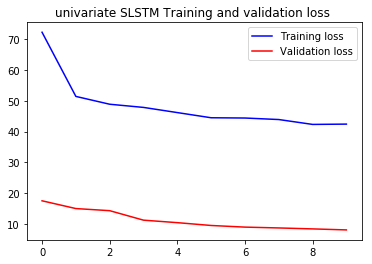

In [138]:
plot_train_history(slstm_history,
                   'univariate SLSTM Training and validation loss ')

## 输出预测结果--sigmoid

In [139]:
slstm_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rnn_6 (RNN)                  (None, 8)                 480       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 489
Trainable params: 489
Non-trainable params: 0
_________________________________________________________________


In [140]:
for x, y in val_univariate.take(1):
    print(slstm_model.predict(x))
    #slstm_model

[[-1.4402826]
 [-1.4315455]
 [-1.4953218]
 [-1.5004935]
 [-1.5235066]
 [-1.4757749]
 [-1.4908068]
 [-1.5344596]
 [-1.4495738]
 [-1.4028071]
 [-1.3963857]
 [-1.2553523]
 [-1.2809055]
 [-1.2178899]
 [-1.243371 ]
 [-1.1816534]
 [-1.3743479]
 [-1.3604305]
 [-1.3765738]
 [-1.6144888]
 [-1.5664258]
 [-1.6645675]
 [-1.6940875]
 [-1.6816528]
 [-1.7992566]]


In [141]:
x_val_uni.shape

(360, 60, 1)

In [142]:
y_val_uni[0]

-1.4537593562977524

In [143]:
#slstm_model.predict(x_val_uni[0])

## 模型保存与调用\数据保存

In [144]:
# 将整个模型保存为HDF5文件
#slstm_model.save('my_model.h5')

In [145]:
# 重新创建完全相同的模型，包括其权重和优化程序--无法正常保存模型-与config的重载有关
#new_model = tf.keras.models.load_model('my_model.h5',custom_objects={'SLSTMCell': SLSTMCell})
#new_model = tf.keras.models.load_model('my_model.h5')
#new_model.summary()

In [146]:
#for x, y in val_univariate.take(1):
#    print(new_model.predict(x))

In [147]:
validation_predict = np.array([])
validation_real = np.array([])

for x, y in val_univariate.take(int((1220-800-univariate_past_history)/BATCH_SIZE)+1):
    res = slstm_model.predict(x)
    res = np.transpose(res)#转置
    y = np.transpose(y)
    
    validation_predict = np.concatenate([validation_predict, res[0]])#向量连接
    validation_real = np.concatenate([validation_real, y])
    
print(validation_predict.shape) 
#之所以只有2批，因为测试集中刨去look_back=60, 1220-800-60=360，而批容量为256；
#当批容量为25，则为360/
#print(res)
print(validation_real.shape)


15
(360,)
(360,)


In [148]:
def recover_data(data, mean, std):
    res = data * std + mean
    return res

In [149]:
validation_predict = recover_data(validation_predict, uni_train_mean, uni_train_std)
validation_real = recover_data(validation_real, uni_train_mean, uni_train_std)
print(validation_predict[1])
print(validation_real[1])

2711.701716080612
2669.485


In [150]:
import pandas as pd
#data = np.array([np.transpose(validation_predict), np.transpose(validation_real)])
data = np.array([validation_predict, validation_real])
data = np.transpose(data)
print(data.shape)
#slstm_validation_result = pd.DataFrame(data, columns=c("predict","real"))
slstm_validation_result = pd.DataFrame(data)
print(slstm_validation_result.head())
slstm_validation_result.to_csv("slstm_M1_sdb2_tanh.csv",index=False)

(360, 2)
             0         1
0  2708.004255  2702.301
1  2711.701716  2669.485
2  2684.712149  2664.800
3  2682.523498  2656.110
4  2672.784544  2686.578


# 单变量多步预测

In [6]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

filename = "stock_sh.csv"
f=open(filename,encoding='UTF-8')
names=['Date','Close','Open','High','Low']
df = pd.read_csv(f,header=0)
df = df[names]
#df = df.set_index("Date", drop = True)
#df = df.set_index("Date")
#print(data[0])
#df.head()
def univariate_data(dataset, 
                    start_index, end_index, 
                    history_size, target_size, 
                    single_step=True):
    '''
    dataset: 自变量
    start_index: 训练集或测试集的第一条所在行
    end_index: 训练集或测试集的最后一条所在行
    history_size: 输入网络的时间跨度，即RNN循环层长度
    target_size: 远期预测的时间跨度，若为下一期，则为0
    single_step: 是否单步预测
    '''
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        #labels.append(dataset[i+target_size])
        
        if single_step:
            labels.append(dataset[i+target_size])
        else:
            labels.append(dataset[i:i+target_size]) 
        
    return np.array(data), np.array(labels)

TRAIN_SPLIT = 800 #这里应该改为1220*0.8
tf.random.set_seed(13)
uni_data = df['Close']
uni_data.index = df['Date']
uni_data.head()
uni_data = uni_data.values
#print(uni_data[1])
#print(len(uni_data))
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()
uni_data = (uni_data-uni_train_mean)/uni_train_std
#print(uni_data[0:24])
#print(uni_data[19])
#print(uni_data[20])

univariate_past_history = 60
univariate_future_target = 5 
#若要单变量单步预测预测下一天，则为0,同时sigle_step=True
#单变量远期预测，若要跳过本周，则为5，同时sigle_step=True
#若要单变量多步预测预测下一天，则为0,同时sigle_step=False


def create_time_steps(length):
    return list(range(-length, 0))

BATCH_SIZE = 25
BUFFER_SIZE = 1000
'''
x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

'''


'\nx_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,\n                                           univariate_past_history,\n                                           univariate_future_target)\nx_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,\n                                       univariate_past_history,\n                                       univariate_future_target)\n\ntrain_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))\ntrain_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()\n\nval_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))\nval_univariate = val_univariate.batch(BATCH_SIZE).repeat()\n\n'

In [264]:
past_history = univariate_past_history
future_target = univariate_future_target
dataset = uni_data
x_train_multi, y_train_multi = univariate_data(dataset, 0,
                                                TRAIN_SPLIT, past_history,
                                                 future_target, single_step=False)
x_val_multi, y_val_multi = univariate_data(dataset,
                                             TRAIN_SPLIT, None, past_history,
                                             future_target,single_step=False)

In [265]:
print ('Single window of past history : {}'.format(x_train_multi.shape))
print ('\nTarget temperature to predict : {}'.format(y_train_multi.shape))

Single window of past history : (740, 60, 1)

Target temperature to predict : (740, 5)


In [266]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [267]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history), label='History')
    plt.plot(np.arange(num_out), np.array(true_future), 'bo',
           label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out), np.array(prediction), 'ro',
             label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

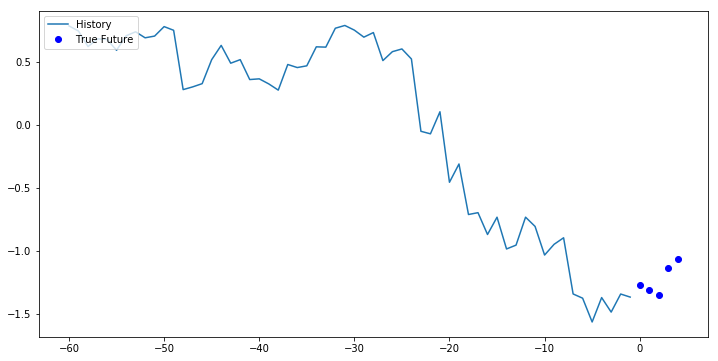

In [268]:
for x, y in train_data_multi.take(1):
    multi_step_plot(x[0], y[0],np.array([0]))

In [190]:
'''
SLSTMLayer = tf.keras.layers.RNN(
    SLSTMCell(8,implementation=1,dropout=0.,use_bias=1), 
    input_shape = x_train_uni.shape[-2:], 
    dynamic=True)
'''

'\nSLSTMLayer = tf.keras.layers.RNN(\n    SLSTMCell(8,implementation=1,dropout=0.,use_bias=1), \n    input_shape = x_train_uni.shape[-2:], \n    dynamic=True)\n'

In [191]:
# 多步预测使用两层LSTM，第一次为32维输出，第二层为16层输出
# 模式2为c, 模式1为x或h
multi_step_model = tf.keras.models.Sequential([
    tf.keras.layers.RNN(
        SLSTMCell(32,implementation=1,dropout=0.,use_bias=1),
        return_sequences=True,
        input_shape = x_train_multi.shape[-2:], 
        dynamic=True),
    tf.keras.layers.RNN(
        SLSTMCell(16,implementation=1,dropout=0.,use_bias=1), #可对activation进行调整
        dynamic=True),
    tf.keras.layers.Dense(future_target)

])


build start
build end
build start
build end


In [192]:
'''
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(5))
'''
#multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), 
#                    loss='mae')
multi_step_model.compile(optimizer='adam', loss='mape')


In [193]:
for x, y in val_data_multi.take(1):
    print (multi_step_model.predict(x).shape)
#查看预测结果的形状

(25, 5)


In [194]:
EPOCHS=10
EVALUATION_INTERVAL = 300

In [195]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=60)

Train for 300 steps, validate for 60 steps
Epoch 1/10
300/300 [==============================] - 457s 2s/step - loss: 77.9225 - val_loss: 22.8102
Epoch 2/10
300/300 [==============================] - 597s 2s/step - loss: 59.9693 - val_loss: 20.8906
Epoch 3/10
300/300 [==============================] - 603s 2s/step - loss: 58.9902 - val_loss: 19.7763
Epoch 4/10
300/300 [==============================] - 622s 2s/step - loss: 58.5380 - val_loss: 20.2633
Epoch 5/10
300/300 [==============================] - 589s 2s/step - loss: 57.1146 - val_loss: 17.0618
Epoch 6/10
300/300 [==============================] - 655s 2s/step - loss: 55.6475 - val_loss: 18.8693
Epoch 7/10
300/300 [==============================] - 945s 3s/step - loss: 52.5722 - val_loss: 17.9181
Epoch 8/10
300/300 [==============================] - 545s 2s/step - loss: 50.1759 - val_loss: 22.2191
Epoch 9/10
300/300 [==============================] - 491s 2s/step - loss: 49.0905 - val_loss: 17.6851
Epoch 10/10
300/300 [=========

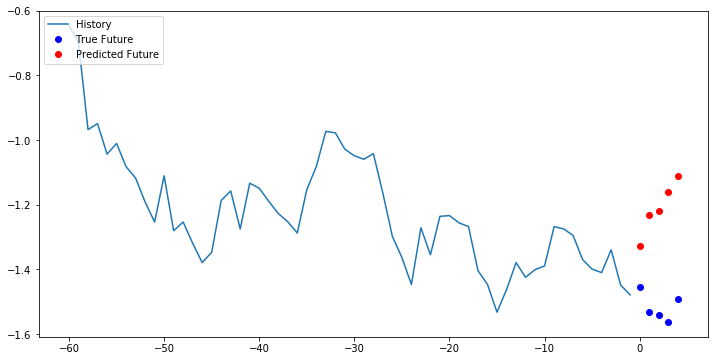

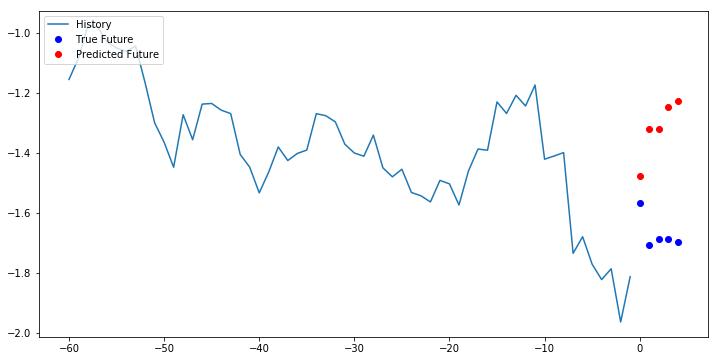

In [196]:
# 散点图两组，第一批的第一条，第二批的第一条
for x, y in val_data_multi.take(2):
    multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])

In [197]:
#暂时保存结果
#model_MAE_Adam_1=multi_step_model
#history_MAE_Adam_1=multi_step_history
#model_MAE_Adam_2sd_hard
#history_MAE_Adam_2sd_hard
#model_MAE_Adam_sd_tanh=multi_step_model
#history_MAE_Adam_sd_tanh = multi_step_history
#model_MAPE_Adam_sd_softmax=multi_step_model
#history_MAPE_Adam_sd_softmax=multi_step_history
#IDK = multi_step_model

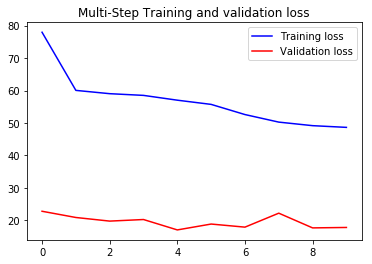

In [198]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

In [199]:
# 数据导出
# 多步预测的全部结果
'''
#之所以只取2个，因为只有2批
#shape：因为测试集中刨去look_back=60, 1220-800-60-5=355 ，
#为什么不是355+1=356？因为没有最后一条，也就是没有最后五天的预测，
#但由于是多步预测，所以本质上只少了最后一天的预测
#但为什么256-99会得到360？批次之间的序号问题导致的！应先合并再提取！
#print(res)
# 420-look_back-target = 类接力的维数
'''
validation_predictAll = np.array([])
validation_realAll = np.array([])
numVali = 1

for x, y in val_data_multi.take(int((1220-800-univariate_past_history)/BATCH_SIZE)+1):
    
    res = multi_step_model(x)
    #res = np.transpose(res)#转置
    print(res.shape)
    #y = np.transpose(y)
    print(y.shape)
    if numVali == 1:
        validation_predictAll = res
        validation_realAll = y
    else:     
        validation_predictAll = np.vstack((validation_predictAll, res))
        validation_realAll = np.vstack((validation_realAll, y))
    numVali = numVali + 1

print(validation_predictAll.shape)
print(validation_realAll.shape)

# 多步预测的部分结果-转化为类接力集合
validation_predict = np.array([])
validation_real = np.array([])
for i in range(validation_predictAll.shape[0]):
    if i % future_target == 0:
        validation_predict = np.concatenate([validation_predict, validation_predictAll[i]])#行向量连接
        validation_real = np.concatenate([validation_real, validation_realAll[i]])

print(validation_predict.shape) 
print(validation_real.shape)
#应为testSize-lookBack-target=420-60-5=355, 缺最后1组target的预测值

def recover_data(data, mean, std):
    res = data * std + mean
    return res

validation_predict = recover_data(validation_predict, uni_train_mean, uni_train_std)
validation_real = recover_data(validation_real, uni_train_mean, uni_train_std)
print(validation_predict[1])
print(validation_real[1])

import pandas as pd
#data = np.array([np.transpose(validation_predict), np.transpose(validation_real)])
data = np.array([validation_predict, validation_real])
data = np.transpose(data)
print(data.shape)
lstm_validation_result = pd.DataFrame(data)
print(lstm_validation_result.head())



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(25, 5)
(25, 5)
(25, 5)
(25, 5)
(25, 5)
(25, 5)
(25, 5)
(25, 5)
(25, 5)
(25, 5)
(25, 5)
(25, 5)
(25, 5)
(25, 5)
(25, 5)
(25, 5)
(25, 5)
(25, 5)
(25, 5)
(25, 5)
(25, 5)
(25, 5)
(25, 5)
(25, 5)
(25, 5)
(25, 5)
(25, 5)
(25, 5)
(5, 5)
(5, 5)
(355, 5)
(355, 5)
(355,)
(355,)
2795.7266781052344
2669.485
(355, 2)
             0         1
0  2756.095914  2702.301
1  2795.726678  2669.485
2  2801.954326  2664.800
3  2826.549008  2656.110
4  2847.273595  2686.578


In [200]:
lstm_validation_result.to_csv("slstm_multi_mape_adam_tanh_M1_T5_sd_hs2.csv",
                              index=False)

# 多变量预测

In [2]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

#filename = "stock_sh.csv"
#filename="stockSZ.csv"
filename="stockJP.csv"
f=open(filename,encoding='UTF-8')
#names=['Date','Close','Open','High','Low']
names=['Date','SH','JP','NS']
df = pd.read_csv(f,header=0)
df = df[names]
#df = df.set_index("Date", drop = True)
#df = df.set_index("Date")
#print(data[0])
#df.head()
TRAIN_SPLIT = 800 #这里应该改为1220*0.8
tf.random.set_seed(13)

#features_considered = ['Close', 'High', 'Low']
#features_considered = ['SH', 'SZ', 'SZZX']
features_considered = ['SH', 'JP', 'NS']

In [3]:
features = df[features_considered]
features.index = df['Date']
features.head()

,SH,JP,NS
Date,,,
2015-03-09,3302.41,18790.55,4412.99
2015-03-10,3286.07,18665.11,4329.08
2015-03-11,3290.90,18723.52,4305.38
2015-03-12,3349.32,18991.11,4336.23
2015-03-13,3372.91,19254.25,4314.90


array([<matplotlib.axes._subplots.AxesSubplot object at 0x110a80eb8>,
      dtype=object)

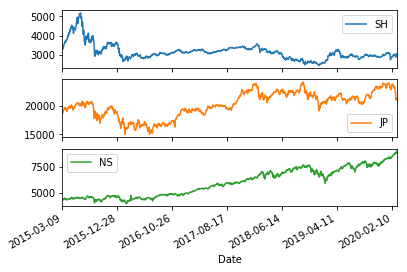

In [4]:
features.plot(subplots=True)

In [5]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

In [6]:
dataset = (dataset-data_mean)/data_std

In [7]:
# 标准化后的值
a = pd.DataFrame(dataset)
a.head()

,0,1,2
0,-0.035705,-0.249777,-0.891149
1,-0.074317,-0.310488,-0.991343
2,-0.062903,-0.282218,-1.019642
3,0.075143,-0.152710,-0.982805
4,0.130886,-0.025354,-1.008274


In [8]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step=1, single_step=False):
    '''
    dataset: 自变量
    target: 因变量
    start_index: 训练集或测试集的第一条所在行
    end_index: 训练集或测试集的最后一条所在行
    history_size: 输入网络的时间跨度，即RNN循环层长度
    target_size: 远期预测的时间跨度，若为下一期，则为0（且single_step=True）
    step: 间隔跨度，若连续，则为1
    single_step: 是否单步预测
    '''
    data = []
    labels = []
    
    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In [9]:
past_history = 60
future_target = 5
#若要直接预测下一周的周一，则为5，single_step=False；否则为0,single_step=True
STEP = 1

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 0], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step = False)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 0],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step = False)

In [10]:
#Let's look at a single data-point.
#训练集中的每一条记录都是一个60x3的矩阵，60是60天，3是3个特征变量。注意，不是3x60。
print('x_val_single，训练集中第一条样本的训练值')
print(x_val_single[0])
print('x_val_single，训练集中第一条样本的标签')
print(y_val_single[0])

x_val_single，训练集中第一条样本的训练值
[[-0.64594905  1.72864572  2.15437494]
 [-0.69854936  1.77125068  2.14125221]
 [-0.96812001  1.66101404  2.15535407]
 [-0.94942871  1.71577179  2.06480844]
 [-1.04375953  1.63280755  2.11427838]
 [-1.01079573  1.43831928  2.08043869]
 [-1.08267809  1.57235817  2.03819282]
 [-1.11772132  1.63895897  2.08509553]
 [-1.19175401  1.55367645  2.07087427]
 [-1.25385356  1.4671985   2.14252986]
 [-1.110845    1.46906183  2.1378372 ]
 [-1.28064994  1.43507176  2.15123456]
 [-1.25387719  1.43440386  2.11018275]
 [-1.31947398  1.45091734  2.1696828 ]
 [-1.37913964  1.21251735  2.15936612]
 [-1.34759364  1.19974506  2.29811599]
 [-1.18719343  1.16659227  2.36932978]
 [-1.15760871  1.08429109  2.39700811]
 [-1.27542772  1.20100341  2.44874677]
 [-1.13390785  1.32879409  2.38038678]
 [-1.14922007  1.39883117  2.38013603]
 [-1.18972183  1.27073074  2.39907383]
 [-1.22731711  1.3945092   2.44767211]
 [-1.25300288  1.59264671  2.44299139]
 [-1.28776256  1.64104977  2.53174594

In [11]:
# 对验证集中标签内容进行还原
y_val_single[0]*data_std[0] + data_mean[0]


array([2702.3 , 2669.49, 2664.8 , 2656.11, 2686.58])

In [12]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (60, 3)


In [13]:
BATCH_SIZE = 50
BUFFER_SIZE = 1000

In [14]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [15]:
# 考虑到有多个变量，将units提升到32
#SLSTMLayer32 = tf.keras.layers.RNN(
#    SLSTMCell(32,implementation=1,dropout=0.,use_bias=1), 
#    input_shape = x_train_single.shape[-2:], 
#    dynamic=True)

In [16]:
#single_step_model = tf.keras.models.Sequential([
#    SLSTMLayer,
#    tf.keras.layers.Dense(future_target)
#])

In [17]:
# 多步预测使用两层LSTM，第一次为32维输出，第二层为16层输出
# 模式2为c, 模式1为x或h
single_step_model = tf.keras.models.Sequential([
    tf.keras.layers.RNN(
        SLSTMCell(32,implementation=1,dropout=0.,use_bias=1),
        return_sequences=True,
        input_shape = x_train_single.shape[-2:], 
        dynamic=True),
    tf.keras.layers.RNN(
        SLSTMCell(16,implementation=1,dropout=0.,use_bias=1), #可对activation进行调整
        dynamic=True),
    tf.keras.layers.Dense(future_target)

])

build start
build end
build start
build end


In [18]:
single_step_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rnn (RNN)                    (None, 60, 32)            6912      
_________________________________________________________________
rnn_1 (RNN)                  (None, 16)                4704      
_________________________________________________________________
dense (Dense)                (None, 5)                 85        
Total params: 11,701
Trainable params: 11,701
Non-trainable params: 0
_________________________________________________________________


In [19]:
#single_step_model = tf.keras.models.Sequential()
#single_step_model.add(tf.keras.layers.LSTM(32,
#                                           input_shape=x_train_single.shape[-2:]))
#single_step_model.add(tf.keras.layers.Dense(1))

In [20]:
single_step_model.compile(optimizer='Adam', loss='mape')

In [21]:
for x, y in val_data_single.take(1):
    print(single_step_model.predict(x).shape)

(50, 5)


In [22]:
EPOCHS=10
EVALUATION_INTERVAL = 300

In [23]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=60)

Train for 300 steps, validate for 60 steps
Epoch 1/10
300/300 [==============================] - 466s 2s/step - loss: 91.4152 - val_loss: 56.5582
Epoch 2/10
300/300 [==============================] - 385s 1s/step - loss: 64.6377 - val_loss: 23.9605
Epoch 3/10
300/300 [==============================] - 405s 1s/step - loss: 55.6238 - val_loss: 30.0075
Epoch 4/10
300/300 [==============================] - 437s 1s/step - loss: 52.4428 - val_loss: 32.2900
Epoch 5/10
300/300 [==============================] - 442s 1s/step - loss: 50.8839 - val_loss: 36.8326
Epoch 6/10
300/300 [==============================] - 415s 1s/step - loss: 48.5487 - val_loss: 28.7126
Epoch 7/10
300/300 [==============================] - 450s 2s/step - loss: 47.2705 - val_loss: 26.1039
Epoch 8/10
300/300 [==============================] - 439s 1s/step - loss: 42.7487 - val_loss: 24.3474
Epoch 9/10
300/300 [==============================] - 438s 1s/step - loss: 41.2244 - val_loss: 24.8316
Epoch 10/10
300/300 [=========

In [152]:
plot_train_history(single_step_history,
                   'Multivariate Model Training and validation loss')

NameError: name 'plot_train_history' is not defined

In [176]:
for x, y in val_data_single.take(1):
    print(single_step_model(x))
    #slstm_model


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

tf.Tensor(
[[-0.9584019  -0.9205079  -0.92020166 -0.9236091  -0.9431862 ]
 [-0.9603628  -0.9232076  -0.9225379  -0.9277484  -0.9470658 ]
 [-1.0036194  -0.9620479  -0.9590054  -0.9592751  -0.97650856]
 [-1.0068568  -0.9657874  -0.95987153 -0.966394   -0.9811351 ]
 [-1.0163686  -0.97475606 -0.9673524  -0.9747612  -0.9882161 ]
 [-0.9628655  -0.92868245 -0.9273293  -0.94501907 -0.9583992 ]
 [-0.9884321  -0.95123875 -0.9520471  -0.9602664  -0.9735789 ]
 [-1.0005494  -0.96174645 -0.9618446  -0.9711775  -0.983

## 单步预测的结果输出

In [53]:
validation_predict = np.array([])
validation_real = np.array([])

print(int((1220-800-univariate_past_history)/25)+1)
for x, y in val_data_single.take(int((1220-800-univariate_past_history)/BATCH_SIZE)+1):
    res = single_step_model.predict(x)
    res = np.transpose(res)#转置
    y = np.transpose(y)
    
    validation_predict = np.concatenate([validation_predict, res[0]])#向量连接
    validation_real = np.concatenate([validation_real, y])
    
print(validation_predict.shape) 
#之所以只有2批，因为测试集中刨去look_back=60, 1220-800-60=360，而批容量为256；
#当批容量为25，则为360/
#print(res)
print(validation_real.shape)
def recover_data(data, mean, std):
    res = data * std + mean
    return res
validation_predict = recover_data(validation_predict, uni_train_mean, uni_train_std)
validation_real = recover_data(validation_real, uni_train_mean, uni_train_std)
print(validation_predict[1])
print(validation_real[1])
import pandas as pd
#data = np.array([np.transpose(validation_predict), np.transpose(validation_real)])
data = np.array([validation_predict, validation_real])
data = np.transpose(data)
print(data.shape)
#slstm_validation_result = pd.DataFrame(data, columns=c("predict","real"))
slstm_validation_result = pd.DataFrame(data)
print(slstm_validation_result.head())


15
(360,)
(360,)
2726.3367330828896
2697.163585643052
(360, 2)
             0            1
0  2720.372275  2721.586588
1  2726.336733  2697.163586
2  2701.500454  2674.939110
3  2696.260282  2666.674943
4  2688.069992  2683.193554


In [54]:
slstm_validation_result.to_csv("Multivariate_slstm_sigle_mape_adam_tanh_T1_RM1_sd_tanh.csv",
                              index=False)

## 多步预测的结果输出

In [25]:
# 数据导出--多步预测
# 多步预测的全部结果
'''
#之所以只取2个，因为只有2批
#shape：因为测试集中刨去look_back=60, 1220-800-60-5=355 ，
#为什么不是355+1=356？因为没有最后一条，也就是没有最后五天的预测，
#但由于是多步预测，所以本质上只少了最后一天的预测
#但为什么256-99会得到360？批次之间的序号问题导致的！应先合并再提取！
#print(res)
# 420-look_back-target = 类接力的维数
'''
univariate_past_history = 60
validation_predictAll = np.array([])
validation_realAll = np.array([])
numVali = 1

for x, y in val_data_single.take(int((1220-800-univariate_past_history-future_target)/BATCH_SIZE)+1):
    
    res = single_step_model(x) #代码重用
    #res = np.transpose(res)#转置
    print(res.shape)
    #y = np.transpose(y)
    print(y.shape)
    if numVali == 1:
        validation_predictAll = res
        validation_realAll = y
    else:     
        validation_predictAll = np.vstack((validation_predictAll, res))
        validation_realAll = np.vstack((validation_realAll, y))
    numVali = numVali + 1

print(validation_predictAll.shape)
print(validation_realAll.shape)

# 多步预测的部分结果-转化为类接力集合
validation_predict = np.array([])
validation_real = np.array([])
for i in range(validation_predictAll.shape[0]):
    if i % future_target == 0:
        validation_predict = np.concatenate([validation_predict, validation_predictAll[i]])#行向量连接
        validation_real = np.concatenate([validation_real, validation_realAll[i]])

print(validation_predict.shape) 
print(validation_real.shape)
#应为testSize-lookBack-target=420-60-5=355, 缺最后1组target的预测值

def recover_data(data, mean, std):
    res = data * std + mean
    return res

validation_predict = recover_data(validation_predict, data_mean[0], data_std[0])
validation_real = recover_data(validation_real, data_mean[0], data_std[0])
print(validation_predict[1])
print(validation_real[1])

import pandas as pd
#data = np.array([np.transpose(validation_predict), np.transpose(validation_real)])
data = np.array([validation_predict, validation_real])
data = np.transpose(data)
print(data.shape)
lstm_validation_result = pd.DataFrame(data)
print(lstm_validation_result.head())



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(50, 5)
(50, 5)
(50, 5)
(50, 5)
(50, 5)
(50, 5)
(50, 5)
(50, 5)
(50, 5)
(50, 5)
(50, 5)
(50, 5)
(50, 5)
(50, 5)
(5, 5)
(5, 5)
(355, 5)
(355, 5)
(355,)
(355,)
2863.275730629287
2669.49
(355, 2)
             0        1
0  2845.462518  2702.30
1  2863.275731  2669.49
2  2897.518610  2664.80
3  2897.968307  2656.11
4  2888.518422  2686.58


In [26]:
lstm_validation_result.to_csv("Multivariate_slstm_multi_mape_adam_tanh_T5NEW_M1S_sdb2_tanh.csv",
                              index=False)